# Market price of real estate

**The goal of the research** is to conduct data analysis of:
1. Parameters of apartments: area, price, number of rooms, ceiling height
2. Factors affecting the price of apartments
3. Top 10 localities with the largest number of ads
4. Segment of apartments located in the city center

  **Initial data**

The initial data is extracted from the `real_estate_data.csv` file. Since the quality of the file is unknown, data pre-processing is required for analysis.
 
The research is divided into four steps:
   1. Data overview 
   2. Pre-processing
   3. New attributes
   4. In-depth analysis

### Step 1. Data overview

In [111]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [265]:
# set up an options for pandas
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('mode.chained_assignment', None)

In [113]:
# read csv file and print our 5 rows
try:
    df = pd.read_csv('/datasets/real_estate_data.csv',
    sep='\t')
except:  
    df = pd.read_csv('C:\YandexPracticumProjects\Project_3_RealEstate/real_estate_data.csv',
    sep='\\t', engine='python')

display(df.sample(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8666,8,3150000.00,46.00,2018-03-26T00:00:00,2,2.60,5.00,28.00,4,NaN,...,6.00,1.00,посёлок Ильичёво,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3756,14,5600000.00,38.00,2017-09-02T00:00:00,1,NaN,23.00,25.00,4,NaN,...,NaN,NaN,Санкт-Петербург,18695.00,16268.00,1.00,51.00,1.00,344.00,120.00
4244,8,7500000.00,80.00,2019-01-07T00:00:00,3,NaN,4.00,52.50,4,NaN,...,7.80,NaN,Санкт-Петербург,37228.00,8452.00,1.00,1596.00,3.00,149.00,25.00
6102,4,4150000.00,52.00,2017-08-07T00:00:00,2,2.50,9.00,32.00,9,NaN,...,5.50,2.00,Санкт-Петербург,26227.00,13066.00,0.00,NaN,0.00,NaN,33.00
22952,7,600000.00,31.20,2017-11-16T00:00:00,1,2.80,2.00,17.60,2,NaN,...,7.00,NaN,поселок станции Вещево,NaN,NaN,NaN,NaN,NaN,NaN,434.00


In [114]:
df.info() # general info about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [115]:
# number of rows before data cleaning
df_init = len(df.index)
print(df_init)

23699


In [116]:
# check missing values
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns={0:'space'})
        .query('space > 0')
        .sort_values(by='space', ascending = True)
        .plot(kind='barh', figsize=(19,6), rot=-5, legend=False, fontsize=16)
        .set_title('Missing values' + "\n", fontsize=22, color='SteelBlue')    
    );    

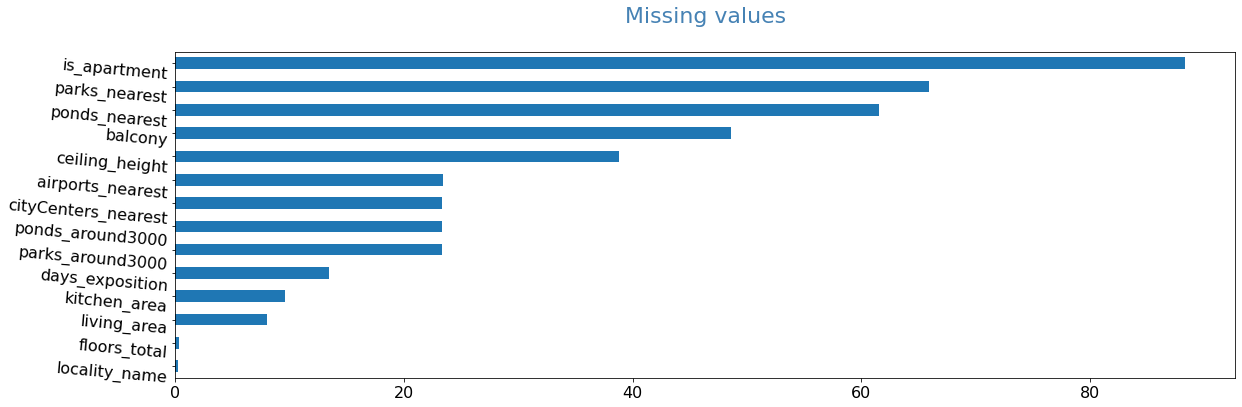

In [117]:
# build a bar chart for missing values
pass_value_barh(df)

### Step 2. Pre-processing

Missing values in 'balcony' and 'floors_total' should be replaced with zeros, because this is probably a user error when filling out.


In [118]:
# fill in NaN with zeros in 'balcony'
df['balcony'] = df['balcony'].fillna(value=0)

In [119]:
# fill in 'days_exposition' with a median value 
df['days_exposition'] = df['days_exposition'].fillna(
    df.groupby('locality_name')['days_exposition'].transform('median')
)

In [120]:
# fill in NaN with 'unknown' in 'is_apartment'
df['is_apartment'] = df['is_apartment'].fillna(value='unknown')

In [121]:
# list of atributes NaN of witch are replaced with median values
env_nan = ['cityCenters_nearest', 
           'parks_around3000', 
           'parks_nearest', 
           'ponds_around3000', 
           'ponds_nearest',
           'ceiling_height']

# fill in NaN with median values
def fill_in_median(data, list_env_nan):
    for i in list_env_nan:
        data[i] = data[i].fillna(data[i].median())
        
fill_in_median(df, env_nan)

In [123]:
# drop rows with NaN values in 'locality_name' 
df = df.dropna(subset=['locality_name'])

The values in 'last_price' and 'floors_total' are converted into int. In the first case, there are no values after the decimal point in the dataframe, in the second case, the number of floors cannot be decimal.

In [124]:
# convert values into int in 'last_price'
df['last_price'] = df['last_price'].astype(int)

In [125]:
# convert values into int in 'floors_total'
df['floors_total'] = df['floors_total'].astype(int)

In [126]:
# convert datatime into yyyy-mm-dd format
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S'
)

Values in columns with integers in float format are also converted into int to ease data analysis

In [127]:
# list of atributes NaN of witch are converted into int
env = ['airports_nearest',
       'living_area',
       'kitchen_area',
       'days_exposition']
       
# convert values into int if there are NaN or float values
def float_to_int(data, list_env):
    for i in list_env:
        data[i] = np.floor(
            pd.to_numeric(data[i], errors='coerce')).astype('Int64')

float_to_int(df, env)

In [128]:
# ckeck columns for missing values
print(df.isna().sum())

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area             1865
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            2222
balcony                    0
locality_name              0
airports_nearest        5524
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition           80
dtype: int64


In [129]:
# leave rows in dataframe if height of ceiling exeeds 2 m
df = df.query('ceiling_height > 2') 

In [130]:
# ckeck unique values in 'ceiling height'
df['ceiling_height'].unique()

array([  2.7 ,   2.65,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.45,   3.6 ,
         2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,   3.62,
         3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,   2.79,
         2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,   4.7 ,
         2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,   3.35,
         2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,   3.83,
         3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,   3.85,
         3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,  32.  ,
         3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,   3.34,
      

In [131]:
# ckeck unique values in 'last_price'
with pd.option_context('display.max_rows', None,):
    print(df['last_price'].sort_values(ascending=True))

8793         12190
17456       430000
14911       430000
16274       440000
17676       450000
16219       450000
5698        450000
9581        450000
21912       470000
18867       470000
23484       470000
16032       480000
6859        490000
10782       490000
14295       500000
2097        500000
14904       500000
4405        500000
22430       520000
12607       530000
1053        550000
13768       550000
7376        550000
7962        550000
1358        550000
11351       550000
22997       560000
19460       560000
8630        560000
13809       565000
10612       580000
8105        585000
15969       590000
21523       600000
23067       600000
10945       600000
18841       600000
18500       600000
20441       600000
22952       600000
6358        600000
1861        600000
12536       600000
11211       600000
8779        620000
15548       630000
21637       630000
20342       630000
11108       630000
3468        650000
268         650000
5689        650000
247         

In [132]:
# leave rows in dataframe if price of apartments exceeds 490000
df = df.query('last_price >= 490000') 

In [133]:
# amount of unique values in 'floors_total'
df['floors_total'].value_counts().sort_values(ascending=True).head(10)

52      1
34      1
33      1
29      1
60      1
36      3
28     21
1      24
35     24
26    124
Name: floors_total, dtype: int64

In [134]:
# percentage of apartments located in buildings lower 27 floors
prop_floors = len(df.query('floors_total < 27')) / len(df)
percent_prop_floors = '{:.0%}'.format(prop_floors)
print('Percentage of apartments located in buildings lower 27 floors =', 
      percent_prop_floors)

Percentage of apartments located in buildings lower 27 floors = 99%


In [135]:
# leave rows in dataframe if floors in buildings are less than 27
df = df.query('floors_total < 27') 

In [136]:
display(df.sample(5)) # print out 5 rows

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
16494,4,3150000,32.00,2018-07-05,1,2.55,5,17,5,unknown,...,6,0.00,Санкт-Петербург,12770,12682.00,0.00,455.00,1.00,712.00,87
13006,6,3800000,62.00,2018-02-01,4,2.70,5,<NA>,3,unknown,...,<NA>,0.00,Всеволожск,<NA>,13098.50,0.00,455.00,1.00,502.00,43
19348,7,4000000,46.00,2015-03-11,2,2.65,9,29,6,unknown,...,7,0.00,Санкт-Петербург,17486,15827.00,1.00,34.00,0.00,502.00,954
69,6,4010000,50.70,2018-09-16,2,2.60,5,28,5,False,...,9,2.00,Выборг,<NA>,13098.50,0.00,455.00,1.00,502.00,194
23064,5,4050000,37.00,2016-02-21,1,2.65,25,17,16,unknown,...,10,0.00,Санкт-Петербург,36553,14693.00,0.00,455.00,0.00,502.00,575


In [137]:
# replace 'ё' with 'е'
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

In [138]:
# locality names
location = ['поселок', 'деревня', 'село', 'город/др']

# create subcategories for locality names
def group_name(x):
    if 'поселок' in x:
        return 'поселок'
    elif 'деревня' in x:
        return 'деревня'
    elif 'село' in x:
        return 'село'      
    else:
        return 'город/др'

# column with subcategories for locality names        
df['group_name'] = df['locality_name'].apply(group_name)

In [139]:
# column with number of unique names of locality
df['loc_count'] = df['locality_name'].map(df['locality_name'].value_counts())

In [140]:
# ckeck unique names in dataset
def check_names(data, group):
    check_df = data.loc[data['group_name'] == group]
    with pd.option_context('display.max_rows', None,):
        print(check_df['locality_name'].value_counts())      

In [141]:
# ckeck a number of unique locality names
check_names(df, location[0])

поселок Мурино                                       479
поселок Шушары                                       438
поселок Парголово                                    268
поселок Бугры                                        112
городской поселок Янино-1                             68
поселок Металлострой                                  65
поселок Стрельна                                      43
поселок Тельмана                                      41
поселок Романовка                                     36
поселок городского типа Кузьмоловский                 35
поселок городского типа имени Свердлова               35
поселок городского типа Рощино                        34
поселок городского типа Сиверский                     29
городской поселок Новоселье                           27
городской поселок Мга                                 26
поселок городского типа Вырица                        22
поселок Новый Свет                                    22
поселок Щеглово                

In [142]:
# ckeck a number of unique countryside names
check_names(df, location[1])

деревня Кудрово               298
деревня Новое Девяткино       143
деревня Старая                 64
деревня Вартемяги              20
деревня Лесколово              20
деревня Бегуницы               17
деревня Большие Колпаны        16
деревня Горбунки               15
деревня Гарболово              13
деревня Мистолово              11
деревня Колтуши                11
деревня Нурма                  11
деревня Гостилицы              11
деревня Малое Верево           11
деревня Белогорка              11
деревня Низино                 10
деревня Сяськелево             10
деревня Лаголово               10
деревня Батово                  9
деревня Малое Карлино           9
деревня Оржицы                  9
деревня Федоровское             8
деревня Калитино                7
деревня Малые Колпаны           7
деревня Извара                  7
деревня Кузьмолово              7
деревня Кипень                  7
деревня Куттузи                 7
деревня Кальтино                7
деревня Пудомя

In [143]:
# ckeck a number of unique village names
check_names(df, location[2])

село Русско-Высоцкое    9
село Павлово            7
село Копорье            5
село Рождествено        3
село Путилово           2
село Паша               2
село Старая Ладога      2
село Никольское         1
село Шум                1
Name: locality_name, dtype: int64


In [144]:
# ckeck a number of cities and other localities
check_names(df, location[3])

Санкт-Петербург                                            15571
Всеволожск                                                   397
Пушкин                                                       369
Колпино                                                      338
Гатчина                                                      307
Выборг                                                       235
Петергоф                                                     201
Сестрорецк                                                   183
Красное Село                                                 176
Кудрово                                                      170
Сертолово                                                    142
Ломоносов                                                    133
Кириши                                                       125
Волхов                                                       111
Сланцы                                                       109
Кингисепп                

In [145]:
# drop rows with rare village names
df = df.drop(df[(df['group_name'] == location[0]) & (df['loc_count'] < 10)].index)

# drop rows with rare countryside names
df = df.drop(df[(df['group_name'] == location[1]) & (df['loc_count'] < 10)].index)

# drop rows with rare city names along with other localities
df = df.drop(df[(df['group_name'] == location[3]) & (df['loc_count'] < 10)].index)    

In [146]:
# rename 'городской поселок' into 'поселок'
df['locality_name'] = df['locality_name'].map(lambda x: x.lstrip('городской '))

In [147]:
# drop explicit dublicates and reset indexes 
df = df.drop_duplicates().reset_index(drop=True)
# ckeck for explicit dublicates
print('Number of explicit dublicates =', (df.duplicated().sum()))

Number of explicit dublicates = 0


In [148]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22620 entries, 0 to 22619
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22620 non-null  int64         
 1   last_price            22620 non-null  int32         
 2   total_area            22620 non-null  float64       
 3   first_day_exposition  22620 non-null  datetime64[ns]
 4   rooms                 22620 non-null  int64         
 5   ceiling_height        22620 non-null  float64       
 6   floors_total          22620 non-null  int32         
 7   living_area           20851 non-null  Int64         
 8   floor                 22620 non-null  int64         
 9   is_apartment          22620 non-null  object        
 10  studio                22620 non-null  bool          
 11  open_plan             22620 non-null  bool          
 12  kitchen_area          20496 non-null  Int64         
 13  balcony         

### Step 3. New attributes

In [149]:
# create a new column 'group_floors'
df['group_location'] = df['locality_name']

# fill in 'group_floors' with values from locality names
# if not 'Санкт-Петербург', replace with 'Other' 
df['group_location'] = df['group_location']\
.where(df['locality_name'] == 'Санкт-Петербург', 'Other')

In [150]:
# create a table to define an average number of floors in buildings
df_grouped_floors = (df.pivot_table(index='group_location', 
                                    values='floors_total', 
                                    aggfunc=['median', 'count'])
)
# rename columns 
df_grouped_floors.columns = ['floors_total', 'count']
# sort values
df_grouped_floors = \
df_grouped_floors.sort_values(by='floors_total', ascending=False)
display(df_grouped_floors.head())

,floors_total,count
group_location,,
Санкт-Петербург,9,15571
Other,6,7049


In [151]:
# calculate a price by square metre of apartments
df['cost_m2'] = (df['last_price'] / df['total_area']).astype(int)

In [152]:
# define day, month and year of ads publications
df['day'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

In [153]:
ground_floor = df['floor'].min() # ground floor in buildings
top_floor = df['floor'].max() # top floor in buildings

In [154]:
# categories of floors
floor_category = ['ground', 'top', 'another']

# filter for floor categories
def floor_cat_func(x):
    if x == ground_floor:
        return floor_category[0]
    elif x == top_floor:
        return floor_category[1]
    else:
        return floor_category[2]

df['floor_category'] = df['floor'].apply(floor_cat_func)

In [155]:
# ratio of living area and total area of apartments
df['living_total_area'] = round(df['living_area'] / df['total_area'], 2)

# ratio of kitchen area and total area of apartments
df['kitchen_total_area'] = round(df['kitchen_area'] / df['total_area'], 2)

In [156]:
df.head(5) # print out 5 rows

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,group_name,loc_count,group_location,cost_m2,day,month,year,floor_category,living_total_area,kitchen_total_area
0,20,13000000,108.00,2019-03-07,3,2.70,16,51,8,unknown,...,город/др,15571,Санкт-Петербург,120370,7,3,2019,another,0.47,0.23
1,7,3350000,40.40,2018-12-04,1,2.65,11,18,1,unknown,...,поселок,438,Other,82920,4,12,2018,ground,0.45,0.27
2,10,5196000,56.00,2015-08-20,2,2.65,5,34,4,unknown,...,город/др,15571,Санкт-Петербург,92785,20,8,2015,another,0.61,0.14
3,0,64900000,159.00,2015-07-24,3,2.65,14,<NA>,9,unknown,...,город/др,15571,Санкт-Петербург,408176,24,7,2015,another,<NA>,<NA>
4,2,10000000,100.00,2018-06-19,2,3.03,14,32,13,unknown,...,город/др,15571,Санкт-Петербург,100000,19,6,2018,another,0.32,0.41


### Step 4. In-depth data analysis

#### 4.1. Analysis of apartment parameters: area, price, number of rooms, height of ceilling

In [157]:
total_area_min = df['total_area'].min() # min area
total_area_max = df['total_area'].max() # max area
print('Min area of apartment:', total_area_min) 
print('Max area of apartment:', total_area_max) 

Min area of apartment: 12.0
Max area of apartment: 900.0


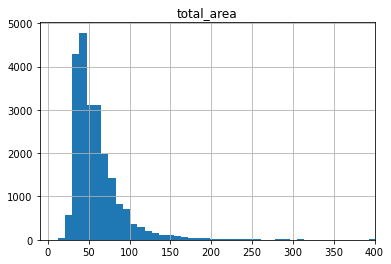

In [158]:
# histogram of apartment total area
df.hist('total_area', bins=100, range=(total_area_min, total_area_max))
plt.xlim(-10, 400);   

In [159]:
last_price_min = df['last_price'].min() # min price
last_price_max = df['last_price'].max() # max price
last_price_median = df['last_price'].mean() # average price
print('Min apartment price:', last_price_min) 
print('Max apartment price:', last_price_max) 
print('Average apartment price:', round(last_price_median)) 

Min apartment price: 490000
Max apartment price: 763000000
Average apartment price: 6695602


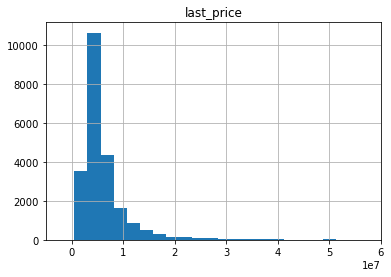

In [160]:
# histogram of apartment price
df.hist('last_price', bins=300, range=(last_price_min, last_price_max)) 
plt.xlim(-0.05e8, 0.6e8);

In [161]:
rooms_min = df['rooms'].min() # min number of rooms
rooms_max = df['rooms'].max() # max number of rooms
print('Min number of rooms:', rooms_min) 
print('Max number of room:', rooms_max) 

Min number of rooms: 0
Max number of room: 19


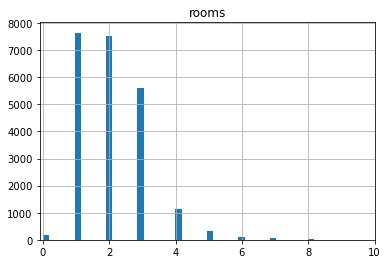

In [162]:
# histogram of number of rooms
df.hist('rooms', bins=100, range=(rooms_min, rooms_max))
plt.xlim(-0.1, 10); 
 

In [163]:
ceiling_height_min = df['ceiling_height'].min() # min height of ceilling
ceiling_height_max = df['ceiling_height'].max() # max height of ceilling
print('Min height of ceilling:', ceiling_height_min) 
print('Max height of ceilling:', ceiling_height_max) 

Min height of ceilling: 2.2
Max height of ceilling: 100.0


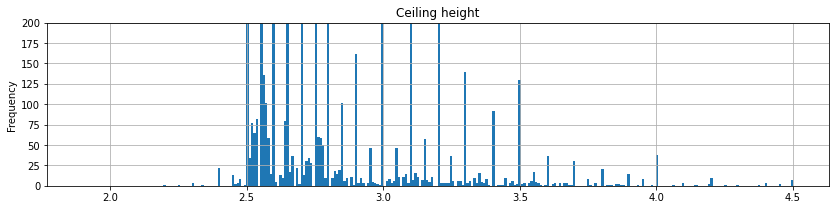

In [164]:
# histogram of ceiling height
(
    df['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', bins=300, range=(1.9,4.5), 
              grid=True, title='Ceiling height', figsize=(14,3))
        .set(ylim = (0, 200))
)
plt.show()

In [165]:
# check dataframe
df[['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition']].describe()

,total_area,last_price,rooms,ceiling_height,days_exposition
count,22620.00,22620.00,22620.00,22620.00,22590.00
mean,60.76,6695602.34,2.08,2.73,169.55
std,36.13,11100624.95,1.09,0.97,207.16
min,12.00,490000.00,0.00,2.20,1.00
25%,40.00,3500000.00,1.00,2.60,45.00
50%,52.02,4700000.00,2.00,2.65,95.00
75%,70.00,6900000.00,3.00,2.70,199.00
max,900.00,763000000.00,19.00,100.00,1580.00


#### 4.2. Analysis of days exposition of apartments

In [166]:
days_exposition_min = df['days_exposition'].min() # Min days exposition of ads
days_exposition_max = df['days_exposition'].max() # Max days exposition of ads
print('Min sale time of apartments:', days_exposition_min) 
print('Max sale time of apartments:', days_exposition_max) 

Min sale time of apartments: 1
Max sale time of apartments: 1580


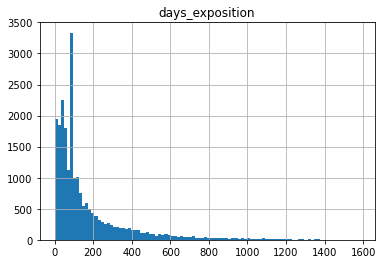

In [167]:
# histogram of days exposition
df.hist('days_exposition', bins=100, range=(days_exposition_min, days_exposition_max))
plt.show()   

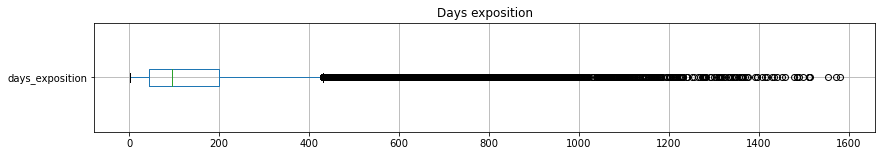

In [168]:
# boxplot of days exposition
fig, ax = plt.subplots(figsize=(14,2))
ax = df[['days_exposition']].boxplot(vert=False, ax=ax)
ax.set_title('Days exposition');

In [169]:
days_exposition_mean = df['days_exposition'].mean()
days_exposition_median = df['days_exposition'].median()
print('Average of days exposition:', round(days_exposition_mean)) 
print('Median of days exposition:', round(days_exposition_median)) 

Average of days exposition: 170
Median of days exposition: 95


The lower "whisker" rests on 0, this is the minimum value. The top end near 400 is 1.5 interquartile range added to the 3rd quartile. This is the approximate limit of the normal range. Everything behind it is considered as an outlier.

According to the median value, most of the sales usually take 95 days. Values ​​below 400 are fast, and sell times closer to 400 are unusually long.

According to Yandex.Support statistics, the sale time for apartments worth from 4.5 to 10 million is 60 days. Data analysis showed a median value of 95 days for apartments with an average cost of 6.7 million. Verification of the results requires analysis of additional parameters, such as distance from the center, as well as the exclusion of outliers in the data.

#### 4.3. Exclusion of outliers

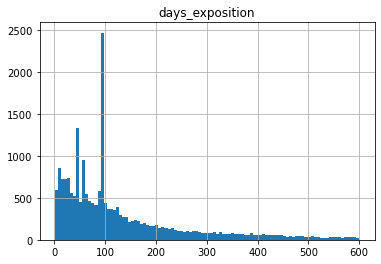

In [170]:
days_exposition_limit = 600 # limit of days exposition

# leave values in 'days_exposition' lower 600
df_filtered = df[df['days_exposition'] < days_exposition_limit] 

# updated histogram of days exposition
df_filtered.hist('days_exposition', bins=100, 
                 range=(days_exposition_min, days_exposition_limit))
plt.show()   

The histogram characterizes the Poisson distribution, the values in the column are now more evenly distributed.

In [171]:
# check dataframe shape
df_filtered.shape

(21438, 32)

In [172]:
# number of rows after filter applied 
df_filtered_rows = len(df_filtered.index)

# percentage of rows left after filter applied
prop_data = df_filtered_rows / df_init
percent_prop_data = '{:.0%}'.format(prop_data)
print('Data left after filter applied:', percent_prop_data)

Data left after filter applied: 90%


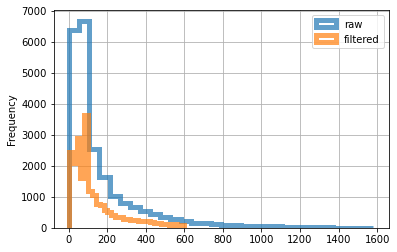

In [173]:
# comparison of histograms 'days_exposition' before and after filter applied
ax = df.plot(
    kind='hist',
    y='days_exposition',
    histtype='step',
    range=(days_exposition_min, days_exposition_max),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='raw',
)
df_filtered.plot(
    kind='hist',
    y='days_exposition',
    histtype='step',
    range=(days_exposition_min, days_exposition_limit),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='filtered',
    ax=ax,
    grid=True,
    legend=True,
);

In [174]:
# indicators for the number of ads in the dataset, 
# min and max values for the sale of apartments
(
    df_filtered[['rooms', 'total_area', 'ceiling_height', 
                 'days_exposition', 'last_price']]
    .apply (['count', 'min', 'max'])   
)

,rooms,total_area,ceiling_height,days_exposition,last_price
count,21438,21438.00,21438.00,21438,21438
min,0,12.00,2.20,1,500000
max,19,900.00,100.00,599,763000000


#### 4.4. Analysis of relationship between parameters affecting the price

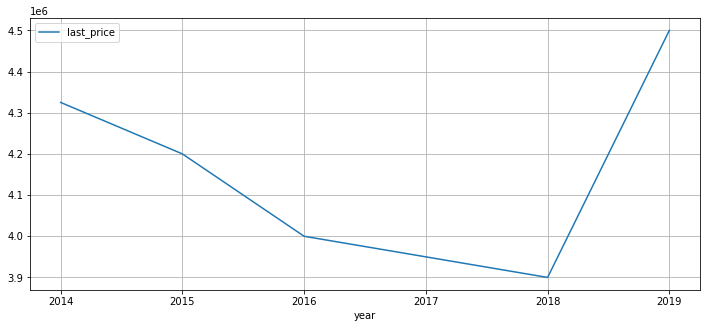

In [175]:
# graph of price of apartments located on the ground floor  
# relative to the year of sale
(
    df_filtered[df_filtered['floor_category'] == 'ground']
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
);   

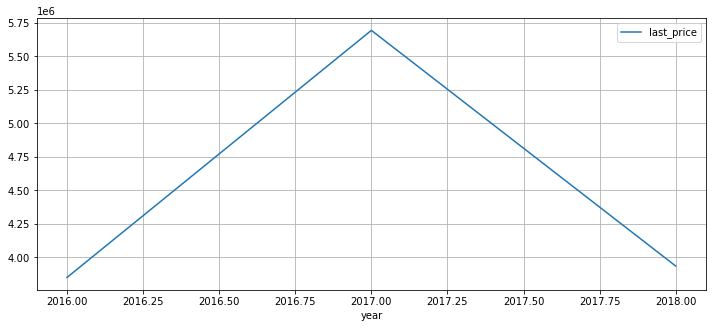

In [176]:
# graph of price of apartments located on the top floor  
# relative to the year of sale
(
    df_filtered[df_filtered['floor_category'] == 'top']
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
);   

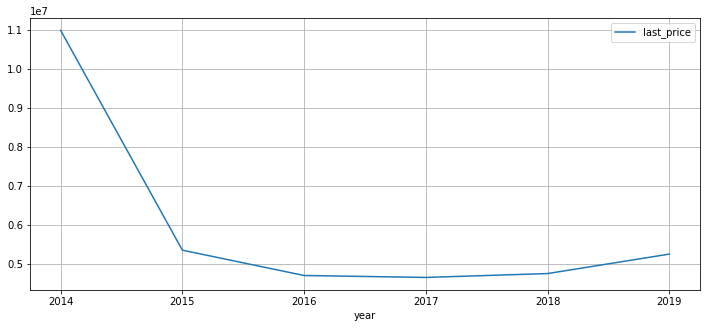

In [177]:
# graph of price of apartments located between the top and ground floors  
# relative to the year of sale
(
    df_filtered[df_filtered['floor_category'] == 'another']
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
);   

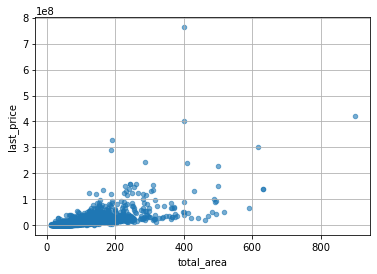

In [178]:
# scatter plot of price versus area
df_filtered.plot(
    x='total_area', y='last_price', kind='scatter', alpha=0.6, grid=True
); 

In [179]:
# Pearson correlation coefficient between price and area
corr_area_cost = df_filtered['total_area'].corr(df_filtered['last_price'])
corr_area_cost_f = '{:.2f}'.format(corr_area_cost)
print('Pearson correlation coefficient between price and area:', 
      corr_area_cost_f)

Pearson correlation coefficient between price and area: 0.65


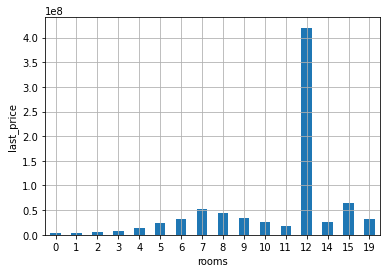

In [180]:
# bar chart of price versus number of rooms
(
    df_filtered.groupby('rooms')['last_price']
    .mean()
    .plot(xlabel='rooms', ylabel='last_price', kind='bar', rot=0, grid=True)
);    

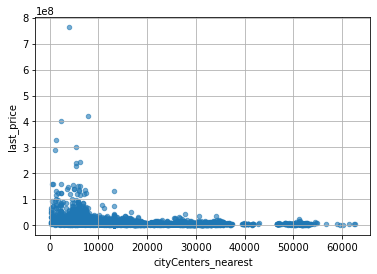

In [181]:
# scatter plot of price versus distance from the city center
df_filtered.plot(
    x='cityCenters_nearest', y='last_price', 
    kind='scatter', alpha=0.6, grid=True
); 

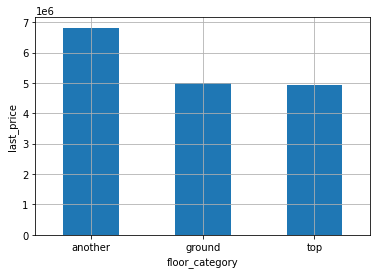

In [182]:
# bar chart of price versus floor in apartment buildings
(
    df_filtered.groupby('floor_category')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
);    

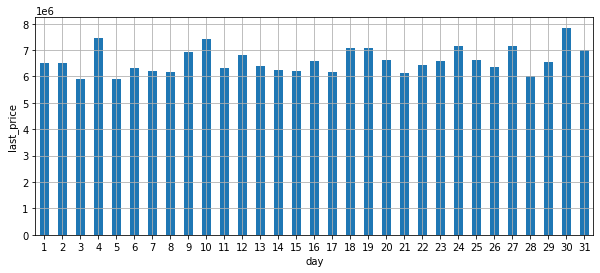

In [183]:
# bar chart of price relative to days of the week
(
    df_filtered.groupby('day')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, figsize=(10, 4), grid=True)
);    

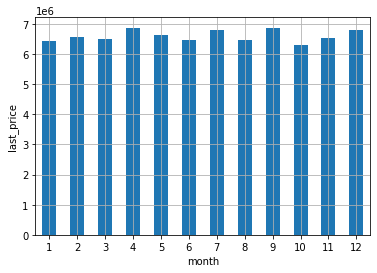

In [184]:
# bar chart of price relative to months
(
    df_filtered.groupby('month')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
);    

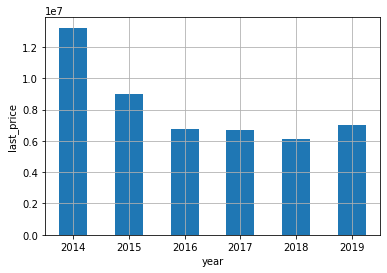

In [185]:
# bar chart of price relative to years
(
    df_filtered.groupby('year')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
);    

In [187]:
# correlation coefficient for 'df_anal' 
print(df_anal.corr()) 

                     last_price  total_area  rooms  cityCenters_nearest
last_price                 1.00        0.65   0.36                -0.19
total_area                 0.65        1.00   0.76                -0.21
rooms                      0.36        0.76   1.00                -0.16
cityCenters_nearest       -0.19       -0.21  -0.16                 1.00


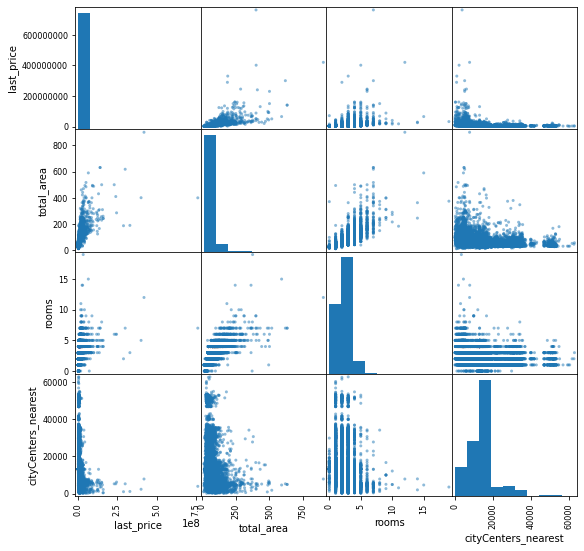

In [188]:
# scatter matrix for 'df_anal' 
pd.plotting.scatter_matrix(df_anal, figsize=(9, 9));

Based on the graphs of relationship between the price and the floor in the apartment buildings, it turns out that until 2018 the price of ground floor apartments falls from 4.3 to 3.9 million, but after 2018 there is a sharp increase to 4.5 million.

The price of apartments except for the ground and top floors also decreases from 11 million to 5 million by 2015. After that, a stable trend is observed until the end of the period.

Relationship between key parameters of apartments are presented in scatterplots and bar charts. In the first case, a strong dependence of the price on the area is expressed, which is also confirmed by the Pearson correlation coefficient equal to 0.65. On the contrary, the dependence of the price on the distance to the city center is quite weak.

The highest price is for apartments with 12 rooms (over 4 million). The diagram also shows the relationship: the fewer rooms, the lower the price. This trend continues for apartments with up to 7 rooms inclusive.

The distribution of the price of apartments between the ground and top floors occurs evenly at the level of 5 million, the apartments located on floors in-between are more expensive by about 2 million.

The time of sale also affects the price of the property. In the middle of the week, the price increases by about 1 million compared to the beginning and end of the week. As can be seen from the distribution by months, the price of housing rises in April, July, September and December to 7 million. The price decreases in October to 6.4 million.

The overall trend of pricing is also shown in the bar chart. Until 2016, there is a sharp decline from 13 to 7 million. Then the price fluctuates around 7 million, with the exception of 2018, when there is a decrease to 6 million.

#### 4.5. Analysis of real estate in 10 settlements with the largest number of ads

In [268]:
# create a new column with ads appearance frequency
df_filtered['top_ads'] = \
df_filtered.groupby('locality_name')['locality_name'].transform('count')
df_filtered.sort_values('top_ads', ascending=False).head();

In [190]:
# build a table and diagram of the top 10 localities with the largest number of ads
# and define localities with the highest and lowest price of housing
class TopCities:
     
     def __init__ (self, data):
          self.data = data
                    
     def top_10_func(self):
          
          top_flat = self.data[['locality_name', 'top_ads', 'last_price']]
          # top 10 localities with the largest number of ads
          top_flat_table = \
          top_flat.groupby('locality_name')\
          .mean()\
          .sort_values('top_ads', ascending=False)\
          .reset_index(drop=False)\
          .head(10)
          
          # round up the price of apartments 
          top_flat_table['last_price'] = top_flat_table['last_price'].astype(int)
          
          return top_flat_table

     def top_10_graph(table):

          # print out the localitiy with the highest price of apartments
          print(table.loc[0, 'locality_name'], 
               'has the larges number of ads in top-10, average price:', 
               table.loc[0, 'last_price'])

          # print out the localities with the smallest price of apartments
          print(table.loc[9, 'locality_name'], 
               'has the smallest number of ads in top-10, average price:', 
               table.loc[9, 'last_price'])          
          
          # build a bar chart of price of apartments
          top_flat_graph = table[['locality_name', 'last_price']]
          top_flat_graph = \
          top_flat_graph.sort_values(by='last_price', ascending=False)\
          .plot(y='last_price', x='locality_name', kind='bar', figsize=(10, 5))     

In [191]:
# build a table of top-10 localities with the highest price of apartments
table_top_10 = TopCities.top_10_func(TopCities(df_filtered))
table_top_10

,locality_name,top_ads,last_price
0,Санкт-Петербург,14733.00,7937027
1,поселок Мурино,461.00,3654447
2,поселок Шушары,424.00,4115417
3,Всеволожск,376.00,3810156
4,Пушкин,349.00,6423267
5,Колпино,329.00,3959362
6,Гатчина,289.00,3506205
7,еревня Кудрово,275.00,4261013
8,поселок Парголово,261.00,4514526
9,Выборг,223.00,3251179


Санкт-Петербург has the larges number of ads in top-10, average price: 7937027
Выборг has the smallest number of ads in top-10, average price: 3251179


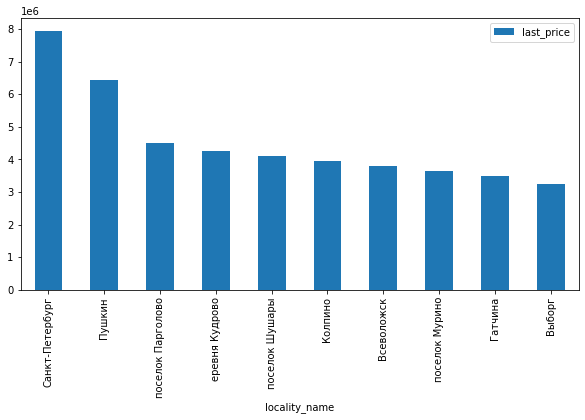

In [192]:
# build a table of top-10 localities with the smallest price of apartments
graph_top_10 = TopCities.top_10_func(TopCities(df_filtered))
TopCities.top_10_graph(graph_top_10 )  

#### 4.6. Analysis of real estate with respect to the distance to the city center

In [266]:
# create a new column with distance to the city center
df_filtered['cityCenters_km'] = df_filtered['cityCenters_nearest']\
    .map(lambda x: x / 1000)\
    .fillna(0)\
    .astype(int)

df_filtered.head()    

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,group_location,cost_m2,day,month,year,floor_category,living_total_area,kitchen_total_area,top_ads,cityCenters_km
0,20.00,13000000.00,108.00,2019-03-07,3.00,2.70,16.00,51,8.00,unknown,...,Санкт-Петербург,120370.00,7.00,3.00,2019.00,another,0.47,0.23,14733.00,16
1,7.00,3350000.00,40.40,2018-12-04,1.00,2.65,11.00,18,1.00,unknown,...,Other,82920.00,4.00,12.00,2018.00,ground,0.45,0.27,424.00,18
2,10.00,5196000.00,56.00,2015-08-20,2.00,2.65,5.00,34,4.00,unknown,...,Санкт-Петербург,92785.00,20.00,8.00,2015.00,another,0.61,0.14,14733.00,13
3,0.00,64900000.00,159.00,2015-07-24,3.00,2.65,14.00,<NA>,9.00,unknown,...,Санкт-Петербург,408176.00,24.00,7.00,2015.00,another,<NA>,<NA>,14733.00,6
4,2.00,10000000.00,100.00,2018-06-19,2.00,3.03,14.00,32,13.00,unknown,...,Санкт-Петербург,100000.00,19.00,6.00,2018.00,another,0.32,0.41,14733.00,8


<AxesSubplot:xlabel='cityCenters_km'>

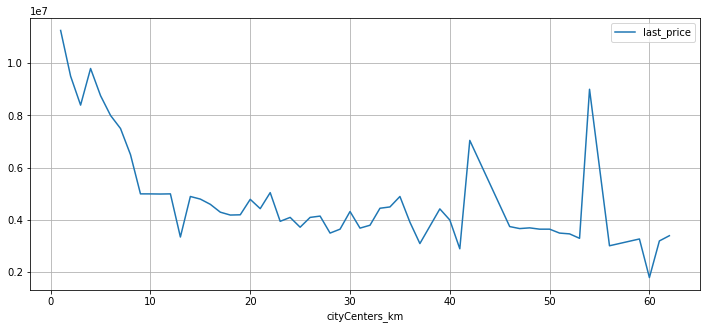

In [194]:
# graph of price of apartment area in m2 
# relative to the distance to the city center
(
  df_filtered[df_filtered['cityCenters_km'] > 0]
  .pivot_table(index='cityCenters_km', values='last_price', aggfunc='median')
  .plot(grid=True, figsize=(12, 5))
)   

As can be seen on the graph, the curve changes dramatically at a distance of 5 km, This is where the city center is located.

#### 4.7. Analysis of a segment of apartments in the city center. Definition of factors affecting the price

In [195]:
# leave apartments located in the city center 
# (distance to the city center is less than 5 km)
df_filtered_center = df_filtered.query('cityCenters_km < 5 and cityCenters_km != 0')
df_filtered_center.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,group_location,cost_m2,day,month,year,floor_category,living_total_area,kitchen_total_area,top_ads,cityCenters_km
22,8,6500000,97.20,2015-10-31,2,2.65,3,46,1,unknown,...,Санкт-Петербург,66872,31,10,2015,ground,0.47,0.20,14733,2
60,2,20000000,118.00,2018-09-11,3,3.00,9,68,7,unknown,...,Санкт-Петербург,169491,11,9,2018,another,0.58,0.14,14733,4
94,32,9600000,90.00,2017-09-26,4,2.65,5,67,2,unknown,...,Санкт-Петербург,106666,26,9,2017,another,0.74,0.09,14733,2
113,20,33000000,180.00,2017-02-17,3,2.90,9,86,8,False,...,Санкт-Петербург,183333,17,2,2017,another,0.48,0.13,14733,4
128,16,6500000,51.80,2018-08-01,2,3.45,6,25,2,unknown,...,Санкт-Петербург,125482,1,8,2018,another,0.48,0.14,14733,3


In [267]:
# create a new column 'group_name'
df_filtered_center['group_name'] = df_filtered_center['locality_name']

# fill in 'group_name' with values from the top-10 localities
# if not in the top-10, replaced with 'Other'
df_filtered_center['group_name'] = df_filtered_center['group_name']\
.where(df_filtered_center['locality_name'].isin(table_top_10['locality_name']), 'Other')

df_filtered_center.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,group_location,cost_m2,day,month,year,floor_category,living_total_area,kitchen_total_area,top_ads,cityCenters_km
16388,5,11000000,143.30,2016-01-28,4,3.10,6,80,5,False,...,Санкт-Петербург,76762,28,1,2016,another,0.56,0.09,14733,3
19044,12,11350000,62.00,2017-12-08,3,3.00,4,38,4,False,...,Санкт-Петербург,183064,8,12,2017,another,0.61,0.16,14733,3
14330,4,10000000,108.00,2015-11-10,3,3.25,6,67,4,False,...,Санкт-Петербург,92592,10,11,2015,another,0.62,0.06,14733,4
20962,9,10400000,101.00,2017-09-04,4,3.00,6,66,2,unknown,...,Санкт-Петербург,102970,4,9,2017,another,0.65,0.10,14733,4
17626,19,9500000,97.00,2017-08-31,2,3.07,4,46,2,unknown,...,Санкт-Петербург,97938,31,8,2017,another,0.47,0.14,14733,3


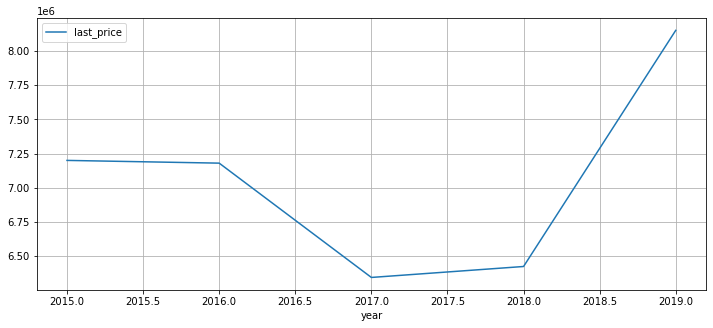

In [197]:
# graph of price of apartments in the city center located on the ground floor  
# relative to the year of sale
(
  df_filtered_center[df_filtered_center['floor_category'] == 'ground']
  .pivot_table(index='year', values='last_price', aggfunc='median')
  .plot(grid=True, figsize=(12, 5))
);   

In [198]:
# top floor of buildings apartmens are located on
top_floor_spb = df_filtered_center.groupby(['group_location'])['floor'].max()
print(top_floor_spb)

group_location
Санкт-Петербург    25
Name: floor, dtype: int64


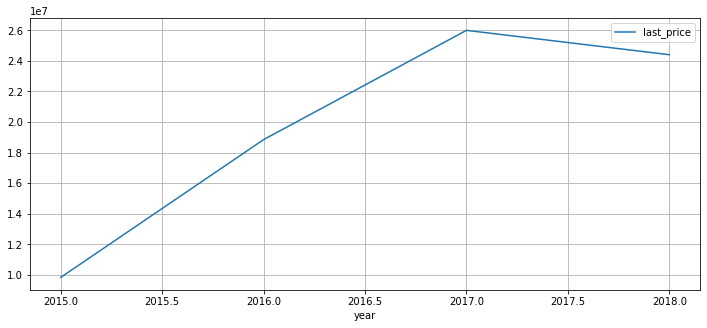

In [199]:
# graph of price of apartments in the city center located on the top floor  
# relative to the year of sale
# dataset for 19th floor due to not enough data for higher floors
(
  df_filtered_center[df_filtered_center['floor'] == 19]
  .pivot_table(index='year', values='last_price', aggfunc='median')
  .plot(grid=True, figsize=(12, 5))
);   

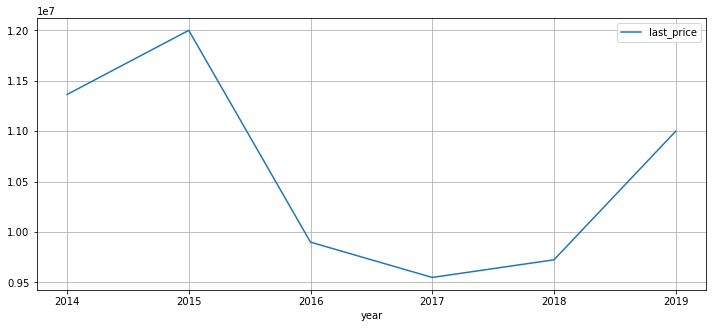

In [200]:
# graph of price of apartments in the city center located between the top 
# and ground floor relative to the year of sale
(
  df_filtered_center[df_filtered_center['floor_category'] == 'another']
  .pivot_table(index='year', values='last_price', aggfunc='median')
  .plot(grid=True, figsize=(12, 5))
);  

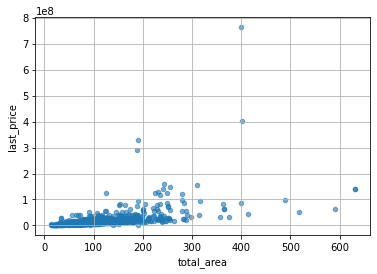

In [201]:
# scatter plot of price versus area of apartments located in the city center
df_filtered_center.plot(
    x='total_area', y='last_price', kind='scatter', alpha=0.6, grid=True); 

In [202]:
# Pearson correlation coefficient between price and area 
# for apartments located in the city center
corr_area_cost_center = df_filtered['total_area']\
.corr(df_filtered_center['last_price'])

corr_area_cost_center_f = '{:.2f}'.format(corr_area_cost_center)
print('Pearson correlation coefficient between price and area:', 
      corr_area_cost_center_f)

Pearson correlation coefficient between price and area: 0.53


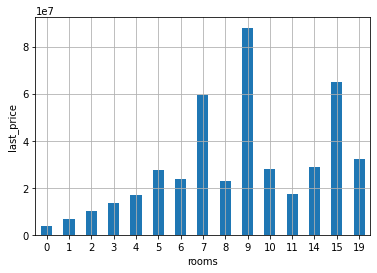

In [203]:
# bar chart of price relative to number of rooms 
# for apartments located in the city center
(
    df_filtered_center.groupby('rooms')['last_price']
    .mean()
    .plot(xlabel='rooms', ylabel='last_price', kind='bar', rot=0, grid=True)
);    

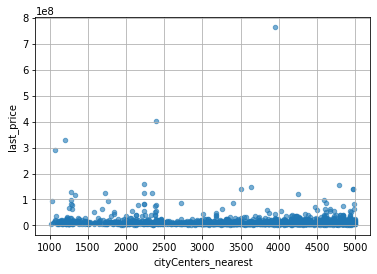

In [204]:
# scatter plot of price versus distance to the city center
# for apartments located in there
df_filtered_center.plot(
    x='cityCenters_nearest', y='last_price', 
    kind='scatter', alpha=0.6, grid=True
); 

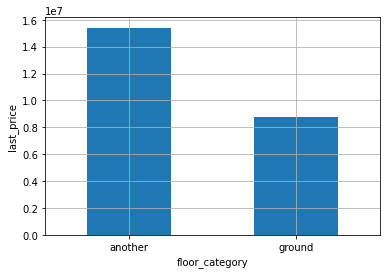

In [205]:
# bar chart of price relative to the floor in buildings 
# for apartments located in the city center
(
    df_filtered_center.groupby('floor_category')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
); 

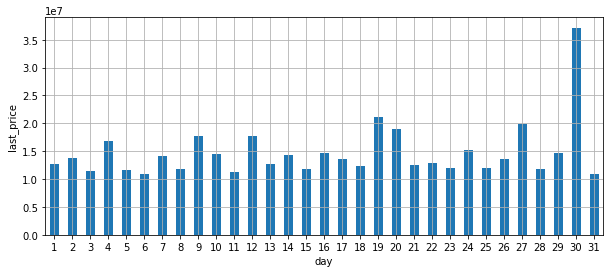

In [206]:
# bar chart of price relative to days of the week 
# for apartments located in the city center
(
    df_filtered_center.groupby('day')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, figsize=(10, 4), grid=True)
);  

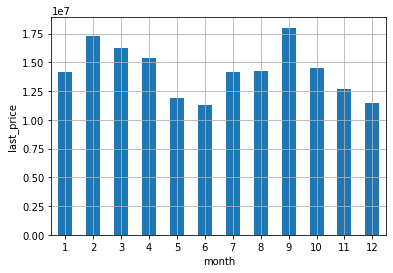

In [207]:
# bar chart of price relative to months 
# for apartments located in the city center
(
    df_filtered_center.groupby('month')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
); 

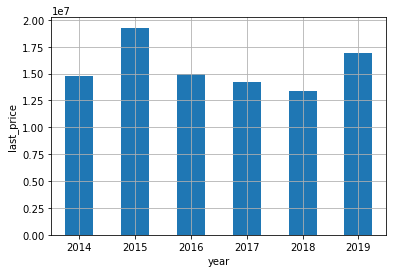

In [208]:
# bar chart of price relative to years 
# for apartments located in the city center
(
    df_filtered_center.groupby('year')['last_price']
    .mean()
    .plot(ylabel='last_price', kind='bar', rot=0, grid=True)
);    

In [209]:
# min area of apartments located in the city center
total_area_center_min = df_filtered_center['total_area'].min()
# max area of apartments located in the city center
total_area_center_max = df_filtered_center['total_area'].max() 
print('Min area of apartments located in the city center:', 
      total_area_center_min) 
print('Max area of apartments located in the city center:', 
      total_area_center_max) 

Min area of apartments located in the city center: 13.0
Max area of apartments located in the city center: 631.2


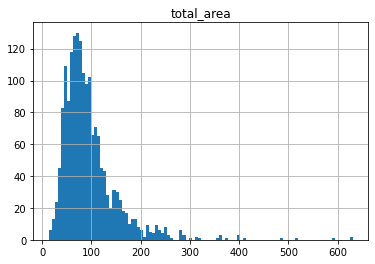

In [210]:
# histogram of area of apartments located in the city center
df_filtered_center.hist(
    'total_area', bins=100, range=(total_area_center_min, 
    total_area_center_max)
)
plt.show()  

In [211]:
# min price for apartments located in the city center
last_price_center_min = df_filtered_center['last_price'].min() 
# max price for apartments located in the city center
last_price_center_max = df_filtered_center['last_price'].max() 
print('Min price for apartments located in the city center:', 
      last_price_center_min) 
print('Max price for apartments located in the city center:', 
      last_price_center_max) 

Min price for apartments located in the city center: 1600000
Max price for apartments located in the city center: 763000000


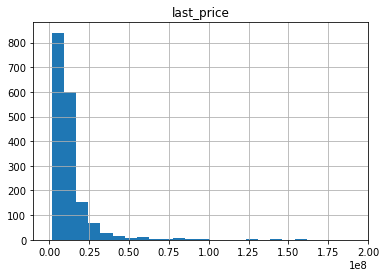

In [212]:
# histogram of price of apartments located in the city center
df_filtered_center.hist(
    'last_price', bins=100, range=(last_price_center_min, 
    last_price_center_max)
);
plt.xlim(-0.1e8, 2e8);                               

In [213]:
# min number of rooms for apartments located in the city center
rooms_center_min = df_filtered_center['rooms'].min() 
# max number of rooms for apartments located in the city center
rooms_center_max = df_filtered_center['rooms'].max() 
print('Min number of rooms for apartments located in the city center:', 
      rooms_center_min) 
print('Max number of rooms for apartments located in the city center:', 
      rooms_center_max) 

Min number of rooms for apartments located in the city center: 0
Max number of rooms for apartments located in the city center: 19


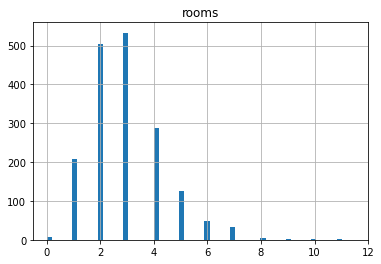

In [214]:
# histogram of number of rooms for apartments located in the city center
df_filtered_center.hist(
    'rooms', bins=100, range=(rooms_center_min, rooms_center_max)
)
plt.xlim(-0.5, 12);                                   

In [215]:
# min ceiling height of apartments located in the city center
ceiling_height_center_min = df_filtered_center['ceiling_height'].min() 
# max ceiling height of apartments located in the city center
ceiling_height_center_max = df_filtered_center['ceiling_height'].max() 
print('Min ceiling height of apartments located in the city center:', 
      ceiling_height_center_min) 
print('Max ceiling height of apartments located in the city center:', 
      ceiling_height_center_max) 

Min ceiling height of apartments located in the city center: 2.4
Max ceiling height of apartments located in the city center: 32.0


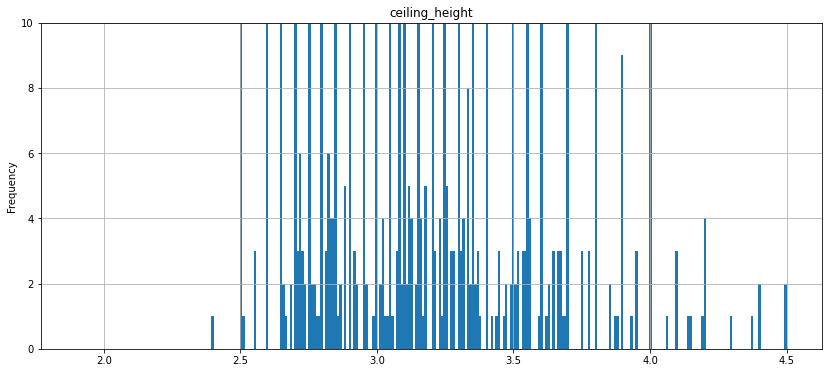

In [216]:
# histogram of ceiling height of apartments located in the city center
(
    df_filtered_center['ceiling_height']
        .sort_values()
        .plot(y='ceiling_height', kind='hist', bins=300, range=(1.9,4.5), 
              grid=True, title='ceiling_height', figsize=(14,6))
        .set(ylim = (0, 10))
)
plt.show()

In [217]:
# new dataframe for analysis of correlation between price, number of rooms
# and distance to the city center for apartments located in there
df_anal_center = df_filtered_center[['last_price', 
                                     'total_area', 
                                     'rooms', 
                                     'cityCenters_nearest']]

In [218]:
# correlation coefficient for 'df_anal_center' 
print(df_anal_center.corr()) 

                     last_price  total_area  rooms  cityCenters_nearest
last_price                 1.00        0.53   0.26                -0.07
total_area                 0.53        1.00   0.74                -0.03
rooms                      0.26        0.74   1.00                -0.05
cityCenters_nearest       -0.07       -0.03  -0.05                 1.00


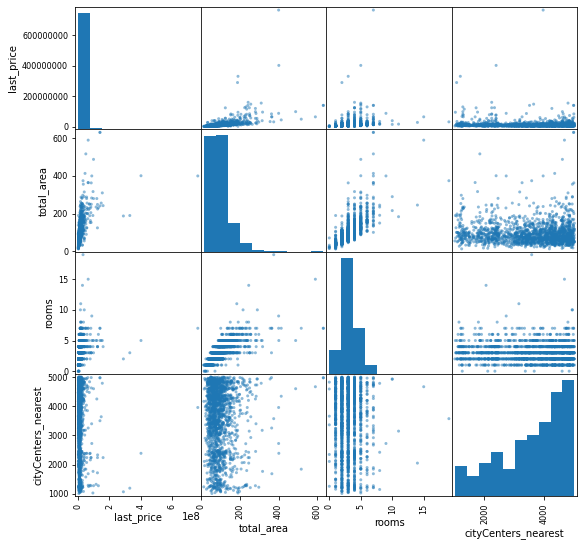

In [219]:
#scatter matrix for 'df_anal_center' 
pd.plotting.scatter_matrix(df_anal_center, figsize=(9, 9));

In [232]:
# number of rooms
floors_number = [1, 2, 3]
# options for analysis
df_select = ['in all localities', 'in the city center']

# calculate the percent of apartments
# in all localities and in the city center
def flat_ratio(data, fl_numb, df_sel):
    prop_floor = len(data[data['floor'] == fl_numb]) / len(data)
    percent_prop_floor = '{:.0%}'.format(prop_floor)
    print('Percentage of apartments with {} rooms {}:'.format(fl_numb, df_sel), 
          percent_prop_floor)

# calculate the average ceiling height of apartments
# in all localities and in the city center
def ceiling_avg(data, fl_numb, df_sel):
    df_ceil_height = data[data['floor'] == fl_numb]
    ceil_height = df_ceil_height['ceiling_height'].mean()
    print('Avg. ceil. height of apartments with {} rooms {}:'.format(fl_numb, df_sel), 
          round(ceil_height, 2), 'm')   

# calculate the time of sale of apartments
# in all localities and in the city center
def sell_time(data, df_sel):
    sell_time_days = data['days_exposition'].mean()
    print('Avg. time of sale for apartments {}:'.format(df_sel), 
          round(sell_time_days), 'days')

# calculate the average price of apartments
# in all localities and in the city center
def price_avg(data, df_sel):
    flat_price = data['last_price'].mean()
    print('Avg. price of apartments {}:'.format(df_sel), 
          round(flat_price), 'rub')

In [233]:
# percentage of apartments with 1 room
flat_ratio(df, floors_number[0], df_select[0])
flat_ratio(df_filtered_center, floors_number[0], df_select[1])
print('-----------------------------------------------------------------------')

# percentage of apartments with 2 rooms
flat_ratio(df, floors_number[1], df_select[0])
flat_ratio(df_filtered_center, floors_number[1], df_select[1])
print('-----------------------------------------------------------------------')

# percentage of apartments with 3 rooms
flat_ratio(df, floors_number[2], df_select[0])
flat_ratio(df_filtered_center, floors_number[2], df_select[1])
print('=======================================================================')

# average ceiling height of apartments with 1 room
ceiling_avg(df, floors_number[0], df_select[0])
ceiling_avg(df_filtered_center, floors_number[0], df_select[1])
print('-----------------------------------------------------------------------')

# average ceiling height of apartments with 2 room
ceiling_avg(df, floors_number[1], df_select[0])
ceiling_avg(df_filtered_center, floors_number[1], df_select[1])
print('-----------------------------------------------------------------------')

# average ceiling height of apartments with 3 room
ceiling_avg(df, floors_number[2], df_select[0])
ceiling_avg(df_filtered_center, floors_number[2], df_select[1])
print('=======================================================================')

# average time of sale for apartments 
sell_time(df, df_select[0])
sell_time(df_filtered_center, df_select[1])
print('=======================================================================')

# average price of apartments
price_avg(df, df_select[0])
price_avg(df_filtered_center, df_select[1])
print('=======================================================================')

Percentage of apartments with 1 rooms in all localities: 12%
Percentage of apartments with 1 rooms in the city center: 13%
-----------------------------------------------------------------------
Percentage of apartments with 2 rooms in all localities: 14%
Percentage of apartments with 2 rooms in the city center: 22%
-----------------------------------------------------------------------
Percentage of apartments with 3 rooms in all localities: 13%
Percentage of apartments with 3 rooms in the city center: 20%
Avg. ceil. height of apartments with 1 rooms in all localities: 2.7 m
Avg. ceil. height of apartments with 1 rooms in the city center: 2.93 m
-----------------------------------------------------------------------
Avg. ceil. height of apartments with 2 rooms in all localities: 2.78 m
Avg. ceil. height of apartments with 2 rooms in the city center: 3.08 m
-----------------------------------------------------------------------
Avg. ceil. height of apartments with 3 rooms in all locali

In [234]:
# parameters for analysis
parameter = ['cost_m2', 'total_area', 'cityCenters_nearest']
# functions for analysis
function = ['median', 'count', 'max', 'min']
# options for sorting
sortout = [True, False]

# build a table with results for St. Petersburg and its region
def param_anal(data, param, func_1, func_2, sort):

    # table for comparison of localities
    table_grouped = (
        data.pivot_table(index='group_location', 
        values=param, aggfunc=[func_1, func_2])
    )
    # rename columns 
    table_grouped.columns = [param, func_2]
    # sort values in the table
    table_grouped = table_grouped.sort_values(by=param, ascending=sort)
    display(table_grouped)

In [235]:
# analysis of the average apartment price by square meter
# in St. Petersburg and its region
param_anal(df_filtered, parameter[0], function[0], function[1], sortout[1])

,cost_m2,count
group_location,,
Санкт-Петербург,104662,14733
Other,70494,6705


In [236]:
# analysis of the average and max area of apartments
# in St. Petersburg and its region
param_anal(df_filtered, parameter[1], function[0], function[2], sortout[1])

,total_area,max
group_location,,
Санкт-Петербург,54.40,900.00
Other,47.00,380.00


In [237]:
# analysis of the average and min area of apartments
# in St. Petersburg and its region
param_anal(df_filtered, parameter[1], function[0], function[3], sortout[1])

,total_area,min
group_location,,
Санкт-Петербург,54.40,12.00
Other,47.00,15.00


In [238]:
# analysis of the average and max distance to the city center
# in St. Petersburg and its region
param_anal(df_filtered, parameter[2], function[0], function[2], sortout[0])

,cityCenters_nearest,max
group_location,,
Санкт-Петербург,12325.00,29493.00
Other,13098.50,62706.00


An analysis of apartments in the city center as well as in all localities shows that the percentage of 1-room apartments is almost the same and amounts to 12% and 13%, respectively. While the percentage of 2- and 3-room apartments in all localities remains unchanged, the proportion for the city center increases to 20%.

The average ceiling height of 1-, 2- and 3-room apartments in St. Petersburg and the region is approximately equal to 2.7 meters. In the city center, the ceiling height is 0.3 meters. In 2- and 3-room apartments these values are largier by 0.1 meters than in 1-room apartments.

The analysis also represents that the average time for the sale of apartments in all localities is longer by 14 days than in the center. At the same time, the average price in the center, equal to 14,574,953 rubles, which is more than 2 times higher than in the city and its region that constitutes 6,695,602 rubles.

In addition, the price of apartments by sq. meters is analysed specifically for St. Petersburg and its region. For a total number of apartments equal to 14,733, the average price is 104,662 rubles per sq. meter. As expected, the price of apartments in the region is significantly lower (70,494 rubles per sq. meter).

The total area of ​​apartments is also an important parameter when comparing. As the research showed, the average total area in St. Petersburg is 54.4 m2, and in its region - 47 m2. While the min areas are approximately the same - 12 and 15 m2, respectively, the difference in the areas of the largest apartments can reach 520 m2.

Due to the fact that most of the apartments offered for sale are located quite far from the city center, the average distance to the city center for St. Petersburg and its region differs slightly, 12.3 km versus 13 km. However, the difference in the biggest distance is approximately 33 km, so that an additional study is needed to find out parameters affecting mostly the price in romote areas.

### Conclusions

In accordance with the goals set, the research consists of 4 main points:
* Studying the parameters of apartments: area, price, number of rooms, ceiling height
* Identification of factors affecting the price of apartments
* Analysis of the top-10 localities with the most ads
* Studying the proposals for sale of apartments located in the city center

A standard methodology is also applied, consisting of four stages:
* Data review
* Pre-processing
* Additional attributes
* In-depth analysis

At the initial stage of the project, parameters such as time for sale of apartments, number of floors, distance to the city center, etc. are removed or replaced with median values. This makes it possible to exclude rare and outlier values ​​in the dataframe. Ceiling height data (less than 2 m) and incorrect names are also filtered out.

Additionally, some of the values ​​are converted to integers (price, number of floors) in order to avoid programming errors in the code when using certain functions and methods. To further visualize the change in parameters, the maximum height of buildings where apartments are located is limited to 27 floors, as they are extremely rare. The total time for sales is limited to 600 days based on the plotted histogram and boxplots.

The correlation between the main parameters affecting the price shows a strong relationship between price and area (Pearson correlation coefficient = 0.65). The relationship between price and number of rooms (Pearson correlation coefficient = 0.36) is in second place . Also, a  pair: number of rooms - total area is indirectly affecting the price, apparently demonstrating the highest degree of correlation (Pearson correlation coefficient = 0.76).

Based on the presented graphs, the highest price of apartments with 12 rooms (more than 4 million rubles). The diagram also depicts the tendency: the fewer rooms, the lower the price. This is applicable for apartments with up to 7 rooms inclusive. The distribution of the price of apartments between the ground and top floors occurs evenly at the level of 5 million rubles, the remaining floors are more expensive by about 2 million rubles. In the top-10 localities St. Petersburg has the largest number of ads with an average price of 7,937,027 rubles. Vyborg has the smallest number of ads with an average price of 3,251,179 rubles. The rest of localities are closer to Vyborg in terms of price (between 3.5 and 4 million rubles) except for Pushkin, whose apartment prices are 6.5 million rubles.

Comparison of apartments in St. Petersburg and its region represents that for a total number of apartments equal to 14,733, the average price in St. Petersburg is 104,662 rubles per sq. meter. As expected, the price of apartments in the region is significantly lower (70,494 rubles per sq. meter). The average total area in St. Petersburg is 54.4 m2, and in the region - 47 m2. While the min areas are approximately the same - 12 and 15 m2, respectively, the difference in the areas of the largest apartments can reach 520 m2.

The next step is to deploy fully-functioned application based on current technical solutions in apartments price analysis including graphical interface for end users, machine learning models for classification and regression, and cloud services to run a program on a GPU, which will significantly speed up data processing.

Besides, further market research will be aimed at identifying certain types of real estate (apartments, houses, production sites, offices, etc.) and their relationship with geographic location, year of construction, overall dimensions and the presence of other infrastructure that affects the price.